# Fetching and playing with a pre-trained VGG Net (16) in Keras

Let's start by importing some packages we need. To simplify things somewhat, we're no longer going to use TensorFlow proper from this point on, we're going to move to a higher-level library called Keras.

In [1]:
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


## Getting a feel for the model and data it is trained on

In this notebook, we're going to fetch a network that is pre-trained on the [ImageNet](http://www.image-net.org) data set. In particular, we're going to fetch the [VGG Net](https://arxiv.org/abs/1409.1556) model with 16 layers (that we're going to refer to as `VGG16`).

ImageNet project is a large visual database designed for use in visual object recognition software research. As of 2016, over ten million URLs of images have been hand-annotated by ImageNet to indicate what objects are pictured. ImageNet crowdsources its annotation process.

![ImageNet Data Sample](https://github.com/sbanerjee2020/NST/blob/master/images/imagenet-sample.jpg?raw=true "ImageNet Data Sample")

Since 2010, the annual ImageNet Large Scale Visual Recognition Challenge (ILSVRC) is a competition where research teams submit programs that classify and detect objects and scenes. (This is like the Olympics of computer vision challenges.)

VGG Net was introduced as one of the contenders in 2014's ImageNet Challenge. VGG Net secured the first and the second places in the localisation and classification tracks respectively. It was later described in great detail in [a paper](https://arxiv.org/abs/1409.1556) that came out the following year. The paper describes how a family of models essentially composed of simple 3x3 convolutional filters with increasing depth (11–19 layers, ReLU not shown for brevity) managed to perform so well at a range of computer vision tasks.

![VGG Network Architectures](https://github.com/sbanerjee2020/NST/blob/master/images/vgg-architecture.png?raw=true "VGG Network Architectures")

We're going to first reproduce this 16 layer network marked in green for classification, and soon see how it can be repurposed for the style transfer problem.

## Fetching a pretrained model in Keras

This is trivial to do in Keras, and can be done in a single line. [There is a selection](https://github.com/fchollet/keras/tree/master/keras/applications) of such models one can import.

In [2]:
model = VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 20s 0us/step


Let's take a look at the model, convince ourselves it looks the same as the paper

In [3]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 28, 28, 512) dtype=float32>,
 'block4_co

We can also get a sense for how many parameters they are in this model.

In [4]:
model.count_params() # A lot!

138357544

## Using it for classification

Now that we have our pre-trained model loaded, we can use it for classification.

### Load an test image and preprocess it

In [0]:
from PIL import Image
import requests

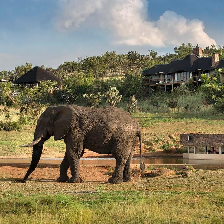

In [6]:
image_url = 'https://github.com/sbanerjee2020/NST/blob/master/images/elephant.jpg?raw=true'
image_from_url = Image.open(requests.get(image_url, stream=True).raw)
image_from_url = image_from_url.resize((224, 224))

image_from_url

In [0]:
# Convert it into an array
x = np.asarray(image_from_url, dtype='float32')
# Convert it into a list of arrays
x = np.expand_dims(x, axis=0)
# Pre-process the input to match the training data
x = preprocess_input(x)

### Classify the test image

The following code classifies the test image and decodes the results into a list of tuples (class, description, probability). There is one such list for each sample in the batch, but since we're only sending in one test image we only get one set of output.

In [8]:
model = VGG16(weights='imagenet', include_top=True)
preds = model.predict(x)
print(preds.shape)
print('Predicted:', decode_predictions(preds, top=3)[0])

(1, 1000)
49152/35363 [=========================================] - 0s 0us/step
('Predicted:', [(u'n02504458', u'African_elephant', 0.84805244), (u'n01871265', u'tusker', 0.102703), (u'n02504013', u'Indian_elephant', 0.049056496)])


## Extension 1: The pre-trained model can be fine-tuned for your own classes

This is classic *transfer learning*. We will not go into this today, but a good worked out example can be found in [the Keras documentation](https://keras.io/applications/).

## Extension 2: Extracting features from a specific layer

We can *extract features* from a specific layer (using the names above).

In [9]:
from keras.models import Model
base_model = VGG16(weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('block4_pool').output)

block4_pool_features = model.predict(x)
print(block4_pool_features)
print(block4_pool_features.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("bl..., inputs=Tensor("in...)`
  This is separate from the ipykernel package so we can avoid doing imports until


[[[[  0.         0.         0.       ...   0.        82.014534
      0.      ]
   [  0.         0.         0.       ...   0.        85.68602
      0.      ]
   [  0.         0.         0.       ...   0.         0.
      0.      ]
   ...
   [  0.         0.         0.       ...   0.       241.86525
      0.      ]
   [  0.         0.         0.       ...   0.       324.13937
      0.      ]
   [  0.         0.         0.       ...   0.       352.3988
      0.      ]]

  [[  0.         0.         0.       ...   0.       223.67087
      0.      ]
   [  0.         0.         0.       ...   0.       235.82382
      0.      ]
   [  0.         0.         0.       ...   0.        58.34267
      0.      ]
   ...
   [  0.       177.63849  143.94608  ...   0.       210.84676
     33.221813]
   [  0.       265.26556  104.58701  ...   0.       115.15332
      0.      ]
   [  0.         0.         0.       ...   0.       921.7363
      0.      ]]

  [[  0.         0.         0.       ...   0.       

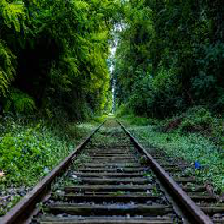

In [10]:
image_url = 'https://github.com/sbanerjee2020/NST/blob/master/images/railroad.jpeg?raw=true'
image_from_url = Image.open(requests.get(image_url, stream=True).raw)
image_from_url = image_from_url.resize((224, 224))

image_from_url

In [0]:
# Convert it into an array
x = np.asarray(image_from_url, dtype='float32')
# Convert it into a list of arrays
x = np.expand_dims(x, axis=0)
# Pre-process the input to match the training data
x = preprocess_input(x)

In [12]:
model = VGG16(weights='imagenet', include_top=True)
preds = model.predict(x)
print (preds.shape)
print(decode_predictions(preds, top=3))
#print('Predicted:', decode_predictions(preds, top=3)[0])

(1, 1000)
[[(u'n04366367', u'suspension_bridge', 0.39486104), (u'n04604644', u'worm_fence', 0.22744395), (u'n03891251', u'park_bench', 0.0392957)]]


In [13]:
model = VGG16(weights='imagenet', include_top=True)
preds = model.predict(x)
print (preds.shape)
print(decode_predictions(preds, top=3))[0]
#print('Predicted:', decode_predictions(preds, top=3)[0])

(1, 1000)
[(u'n04366367', u'suspension_bridge', 0.39486104), (u'n04604644', u'worm_fence', 0.22744395), (u'n03891251', u'park_bench', 0.0392957)]


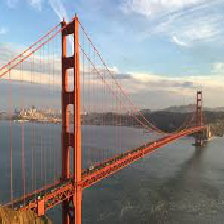

In [14]:

image_url = 'https://github.com/sbanerjee2020/NST/blob/master/images/gg.jpg?raw=true'
image_from_url = Image.open(requests.get(image_url, stream=True).raw)
image_from_url = image_from_url.resize((224, 224))

image_from_url

In [0]:
# Convert it into an array
x = np.asarray(image_from_url, dtype='float32')
# Convert it into a list of arrays
x = np.expand_dims(x, axis=0)
# Pre-process the input to match the training data
x = preprocess_input(x)

In [16]:
model = VGG16(weights='imagenet', include_top=True)
preds = model.predict(x)
print (preds.shape)
print(decode_predictions(preds, top=3))[0]
#print('Predicted:', decode_predictions(preds, top=3)[0])

(1, 1000)
[(u'n04366367', u'suspension_bridge', 0.57035285), (u'n03933933', u'pier', 0.34368858), (u'n03095699', u'container_ship', 0.047337625)]


In [0]:

def identify_image(image_name, num=1):
  image_url_path = "https://github.com/sbanerjee2020/NST/blob/master/images/" + image_name + "?raw=true" 
  print(image_url_path)
  test_image = Image.open(requests.get(image_url_path, stream=True).raw)
  test_image = test_image.resize((224, 224))
  x = np.asarray(test_image, dtype='float32')
  # Convert it into a list of arrays
  x = np.expand_dims(x, axis=0)
  # Pre-process the input to match the training data
  x = preprocess_input(x)
  model = VGG16(weights='imagenet', include_top=True)
  preds = model.predict(x)
  #print (preds.shape)
  print('Predicted:', decode_predictions(preds, top=num)[0])
  return  test_image

https://github.com/sbanerjee2020/NST/blob/master/images/gg.jpg?raw=true
('Predicted:', [(u'n04366367', u'suspension_bridge', 0.57035285), (u'n03933933', u'pier', 0.34368858), (u'n03095699', u'container_ship', 0.047337625)])


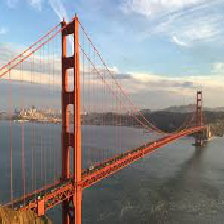

In [18]:
gg = identify_image('gg.jpg', 3)
gg

https://github.com/sbanerjee2020/NST/blob/master/images/harker.jpg?raw=true
('Predicted:', [(u'n03877845', u'palace', 0.18121551), (u'n09332890', u'lakeside', 0.12211219), (u'n03930313', u'picket_fence', 0.10020554), (u'n03899768', u'patio', 0.09271635), (u'n02859443', u'boathouse', 0.08805625)])


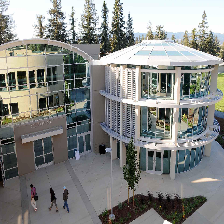

In [19]:
harker = identify_image('harker.jpg', 5)
harker

https://github.com/sbanerjee2020/NST/blob/master/images/elephant.jpg?raw=true
('Predicted:', [(u'n02504458', u'African_elephant', 0.84805244)])


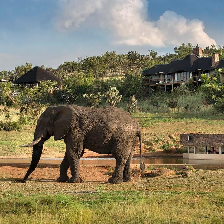

In [20]:
identify_image('elephant.jpg',1)

https://github.com/sbanerjee2020/NST/blob/master/images/cheetah.jpg?raw=true
('Predicted:', [(u'n02130308', u'cheetah', 0.999637), (u'n02117135', u'hyena', 0.0002882549), (u'n02423022', u'gazelle', 2.6682455e-05), (u'n02128385', u'leopard', 1.9539666e-05)])


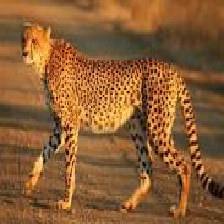

In [21]:
cc = identify_image('cheetah.jpg', 4)
cc

https://github.com/sbanerjee2020/NST/blob/master/images/fish.jpg?raw=true
('Predicted:', [(u'n02177972', u'weevil', 0.25451723), (u'n02168699', u'long-horned_beetle', 0.23387843), (u'n02165105', u'tiger_beetle', 0.13541992)])


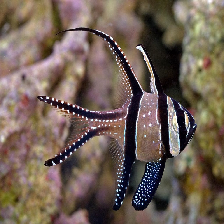

In [22]:
identify_image('fish.jpg', 3)